# Survival Analysis FS

## Import Libraries

In [1]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.inspection import DecisionBoundaryDisplay


sns.set_theme(style='white')

## Load Datasets

In [2]:
input_path = '../Data/'
output_path = '../Data/'

In [3]:
import pandas as pd

x_train = pd.read_pickle(input_path+'embedding.pkl')
x_test = pd.read_pickle(input_path+'embedding_test.pkl')

y = pd.read_csv(input_path+'y.csv', index_col=0)

y_train = y[~y['Clinical Trial'].isin(['AML02','AML08'])]
y_train = y_train[y_train['os.evnt'].notnull()]
y_test = y[y['Clinical Trial'].isin(['AML02','AML08'])]

# Select samples in x that are in y_train
x_train = x_train.loc[y_train.index].to_numpy()
x_test = x_test.loc[y_test.index].to_numpy()

y_test.shape, y_train.shape

((204, 296), (1093, 296))

## Hyperparameter Tuning by GridSearch

### Nearest Neighbors

In [5]:
parameters = {
    'n_neighbors': [2, 5, 7, 8, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

estimator = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
knn = grid_search.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [6]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=10)

### Radial Basis Function (RBF) SVM 

In [7]:
parameters = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
}

estimator = SVC()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
rbf_svm = grid_search.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [8]:
grid_search.best_estimator_

SVC(C=0.1, gamma=0.1)

### Gaussian Process

In [9]:
parameters = {
    'max_iter_predict': [100, 200, 500, 1000]
}

estimator = GaussianProcessClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
best_model = model # Put this wherever you want
gpc = grid_search.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [10]:
grid_search.best_estimator_

GaussianProcessClassifier()

### Random Forest

In [11]:
parameters = {
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400]
}

estimator = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
rfc = grid_search.best_estimator_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [12]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200)

### Neural Net

In [13]:
parameters = {
    'hidden_layer_sizes': [(100,), (200,), (50,), (100, 50,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001],
    'batch_size': [32, 64, 100],
    'max_iter': [500, 1000],
}

estimator = MLPClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
mlp = grid_search.best_estimator_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


In [14]:
grid_search.best_estimator_

MLPClassifier(activation='tanh', batch_size=32, hidden_layer_sizes=(100, 50),
              max_iter=500)

### Naive Bayes

In [15]:
parameters = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-5]
}

estimator = GaussianNB()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
nb = grid_search.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [16]:
grid_search.best_estimator_

GaussianNB(var_smoothing=1e-10)

### Quadratic Discriminant Analysis

In [17]:
parameters = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5],
    'store_covariance': ['true', 'false'],
    'tol': [1e-4, 1e-2, 1, 10]
}

estimator = QuadraticDiscriminantAnalysis()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
qda = grid_search.best_estimator_

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [18]:
grid_search.best_estimator_

QuadraticDiscriminantAnalysis(store_covariance='true')

### XGBoost

In [19]:
parameters = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'max_depth': range(2, 6, 10),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1, 10]
}

estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
xgb = grid_search.best_estimator_

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [20]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1, reg_lambda=1, ...)

### Logistic Regression

In [21]:
parameters = {
    'tol': [1e-4, 1e-2, 1, 10],
    'C': [0.5, 1.0, 1.5],
    'max_iter': [100, 200],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'class_weight': ['balanced', None],
}

estimator = LogisticRegression(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
lr = grid_search.best_estimator_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


In [22]:
grid_search.best_estimator_

LogisticRegression(C=0.5, n_jobs=-1, random_state=42, tol=10)

## Define Classifiers

## XGBoost 

In [8]:
parameters = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'max_depth': range (2, 6, 10),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1, 10]
}

estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs=-1,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
xgboost = grid_search.best_estimator_
print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
COG OS ROC AUC: 0.767 
StJude OS ROC AUC: 0.676 


In [9]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Random Forest",
    "Neural Net",
    "Naive Bayes",
    "QDA",
    "XGBoost",
    "Logistic Regression"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(random_state=42, n_jobs=-1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(activation='tanh', alpha=0.001, batch_size=100,
              hidden_layer_sizes=(50,), max_iter=1000),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgboost,
    LogisticRegression()
]

## Plot classifiers

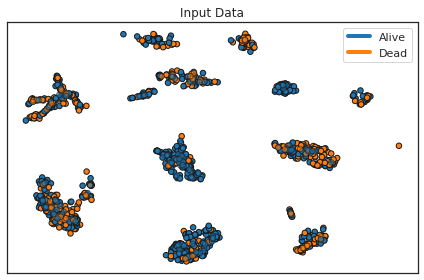

In [138]:
cm_bright = ListedColormap(['#1f77b4', '#ff7f0e'])
#cm = LinearSegmentedColormap.from_list("", ['#1f77b4', '#ff7f0e'])
cm = ListedColormap(['#1f77b4', '#ff7f0e'])

ax = plt.subplot() 
# Plot the training points
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train["os.evnt"], cmap=cm_bright, edgecolors="k", s=30)
# Plot the testing points
ax.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test["os.evnt"], cmap=cm_bright, alpha=0.6, edgecolors="k", s=30
)


# Set Legend
custom_lines = [Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]
ax.legend(custom_lines, ['Alive', 'Dead'])
    
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Input Data")

plt.tight_layout()
plt.show()

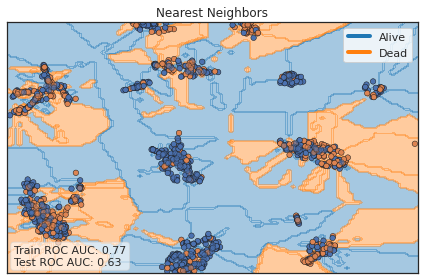

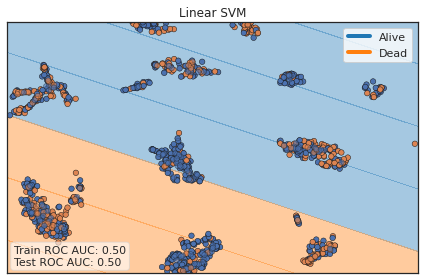

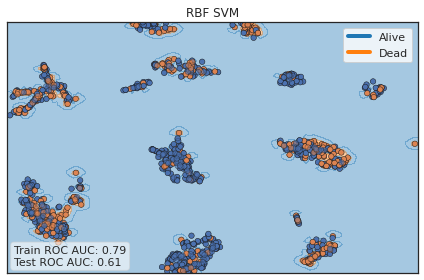

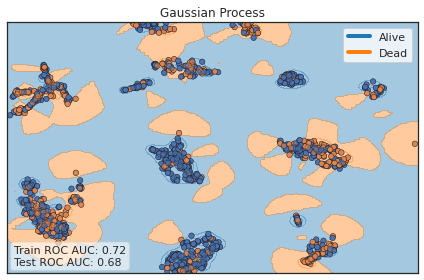

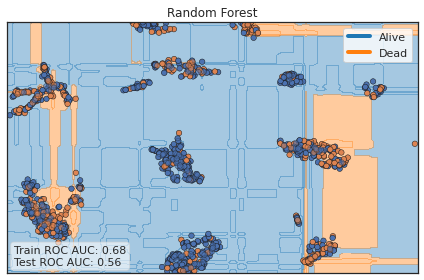

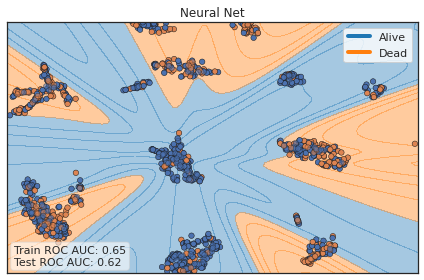

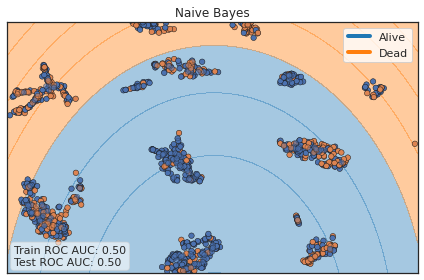

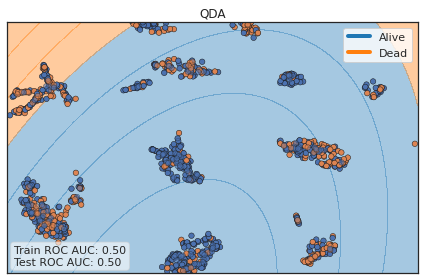

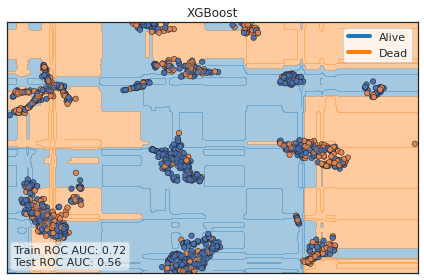

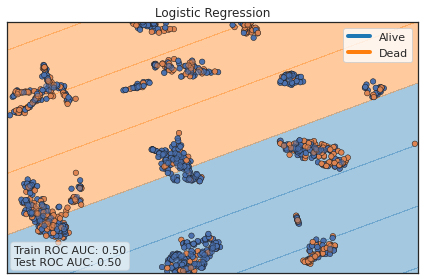

In [139]:
for name, clf in zip(names, classifiers):
    ax = plt.subplot()

    x_min, x_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
    y_min, y_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5

    # Test classifier
    clf.fit(x_train, y_train['os.evnt'])
    
    train_pred = clf.predict(x_train)
    train_score = roc_auc_score(y_train['os.evnt'], train_pred)
    
    test_pred = clf.predict(x_test)
    test_score = roc_auc_score(y_test['os.evnt'], test_pred)
    
    DecisionBoundaryDisplay.from_estimator(
        clf, x_train, cmap=cm, alpha=0.4, ax=ax, eps=0.5
    )

    sns.scatterplot(data=x_train, x=x_train[:, 0], y=x_train[:, 1], s=30, legend='full', 
                    hue=y_train['os.evnt'], linewidth=0.5, alpha=1, ax=ax,edgecolor='k')
    
    sns.scatterplot(data=x_test, x=x_test[:, 0], y=x_test[:, 1], s=30, legend='full', 
                linewidth=0.5, ax=ax,edgecolor='k', alpha=0.6, hue=y_test['os.evnt'])
    
    # Set Legend
    custom_lines = [Line2D([0], [0], color='#1f77b4', lw=4),
                    Line2D([0], [0], color='#ff7f0e', lw=4)]
    ax.legend(custom_lines, ['Alive', 'Dead'])

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)

    ax.annotate(text = f'Train ROC AUC: {train_score:.2f}\nTest ROC AUC: {test_score:.2f}',
           xy=(x_min+1.25, y_min + 4.5), xycoords='data',
           ha='left', va='center', fontsize=11,
           bbox={'boxstyle': 'round', 'facecolor': 'white',
                 'edgecolor': 'lightgray', 'alpha': 0.6})
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    plt.savefig('../Figures/Classifiers/' + name + '_Classifier.png',
                    bbox_inches='tight', dpi=300)
    
    plt.show()